# CNN Fashion Embedding for Recommendation System
    
![fashion-rec](https://miro.medium.com/max/1400/1*o0L2Df6Cr6DEJ0uI-f4z6Q.png)
source: [Building a Women’s Fashion Recommender](https://medium.com/@sjacks/building-a-womens-fashion-recommender-2683856b97e3)

* Hi welcome, first i want to thanks to Marlesson for share this [kernel](https://www.kaggle.com/marlesson/building-a-recommendation-system-using-cnn-v2), i made a few changes in this notebook
* We will use embeddings and Transfer Learning to identify similar items
* Then this information will be used to recommend similar content in Recommendation System

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

## What is Embedding ?

An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Embeddings make it easier to do machine learning on large inputs like sparse vectors representing words. Ideally, an embedding captures some of the semantics of the input by placing semantically similar inputs close together in the embedding space. An embedding can be learned and reused across models.

Neural network embeddings have 2 primary purposes:

* Dimensionality Reduction — **more efficient** representation
* Finding nearest neighbors in the embedding space - These can be used to make recommendations based on user interests or cluster categories.

## Transfer Learning

If we want to make a machine learning model from scratch, we must collecting training dataset, do feature engineering, tuning a hyperparameter then test the model quality. This can consume a lot of time, energy even money if you train in the cloud service use GPU or TPU. More importantly, this model might not give satisfying results in the end.

Do you know ImageNet challenge?

![imagenet](https://miro.medium.com/max/1276/1*OHRF4gFSRuhuJyu5zs7PSA.jpeg)

Let's think about this: "Can our laptop train deep learning model use 1.200.000 image dataset?". Due of RAM limitations we cannot do this, instead we must use cloud computing to train this model. Also is really hard to tuning a model that can make great predictions on 1.000 objects

So what's the solution?

Big company or famous university like Google, Facebook, Stanford, MIT etc already make a great Deep Learning model in computer vision and NLP. These models are trained using huge dataset, tuned by best researcher in the world, also using a very expensive computer or cloud TPU. Thankfully these pre-trained models are open-source, so we can download and use it for free

1. We can use pre-trained model with pretrained weights to directly make a prediction
1. We also can use that model without load pretrained-weights
1. Even we can changing and retraining different task-specific layers or the output layer

> Transfer learning has several benefits, but the main advantages are  saving training time, better performance of neural networks (in most cases), and not needing a lot of data.

## Data Cleaning

1. Due to ram limitations in kaggle kernel (max 16GB), i only use 15000 images in dataset
1. There are some error rows in dataset, we must use error_bad_lines=False to for automatic skip rows these rows

In [2]:
style_df = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/styles.csv', error_bad_lines=False, nrows=15000)
images_df = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/images.csv')

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\n'


In [3]:
# Because of some rows error, we must reset_index
style_df = style_df.reset_index(drop=True)

# Make image_path feature
style_df['image_path'] = style_df['id'].apply(lambda row: '/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/images/' + str(row) + '.jpg')

In [4]:
style_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-dataset/f...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-dataset/f...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,/kaggle/input/fashion-product-images-dataset/f...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,/kaggle/input/fashion-product-images-dataset/f...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,/kaggle/input/fashion-product-images-dataset/f...


## Show random images

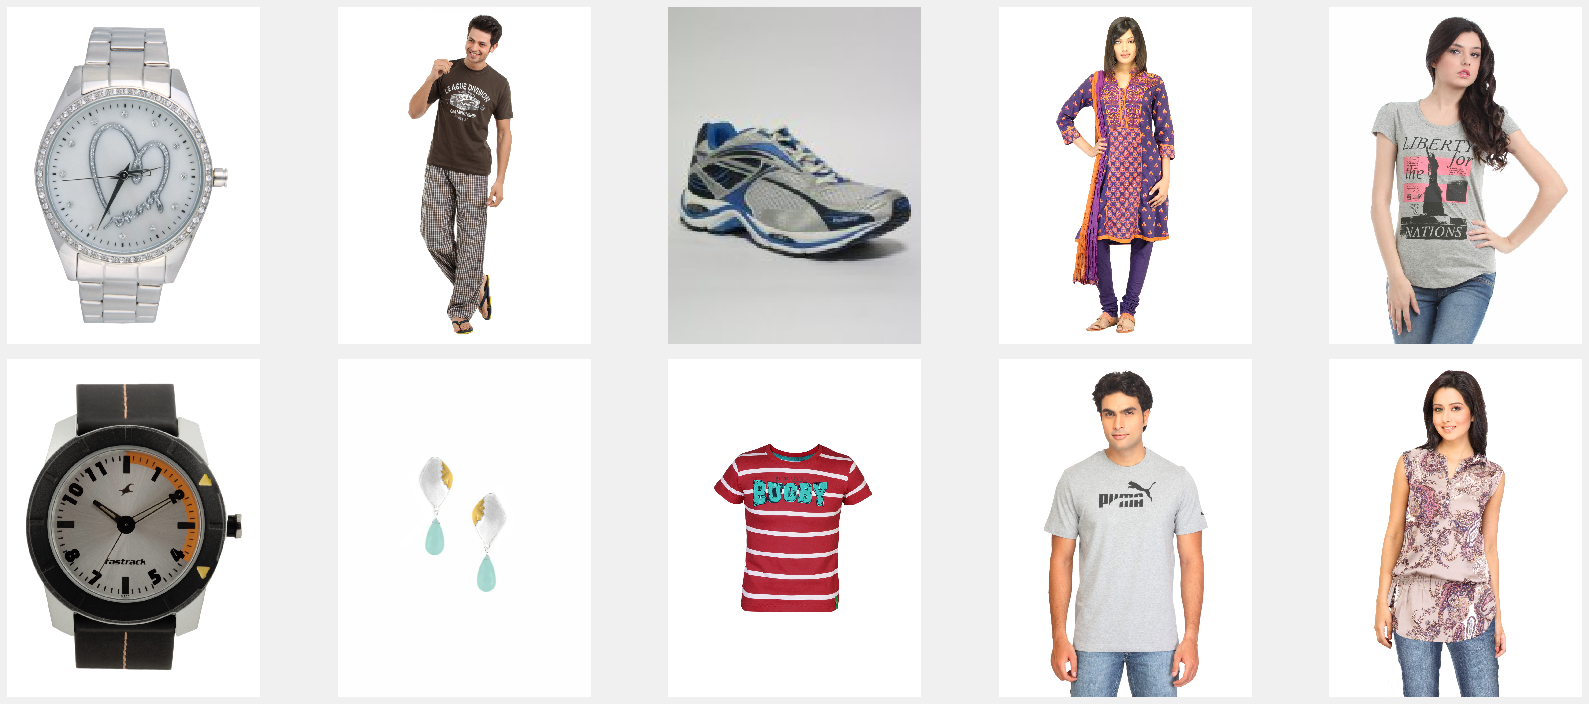

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))

random_img = style_df['image_path'].sample(10).values
random_img = [cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in random_img]

for idx, img in enumerate(random_img):
    if idx <= 4:
        axes[0, idx].imshow(img)
        axes[0, idx].axis('off')
    else:
        axes[1, idx-5].imshow(img)
        axes[1, idx-5].axis('off')
        
plt.tight_layout()
plt.show()

## EDA

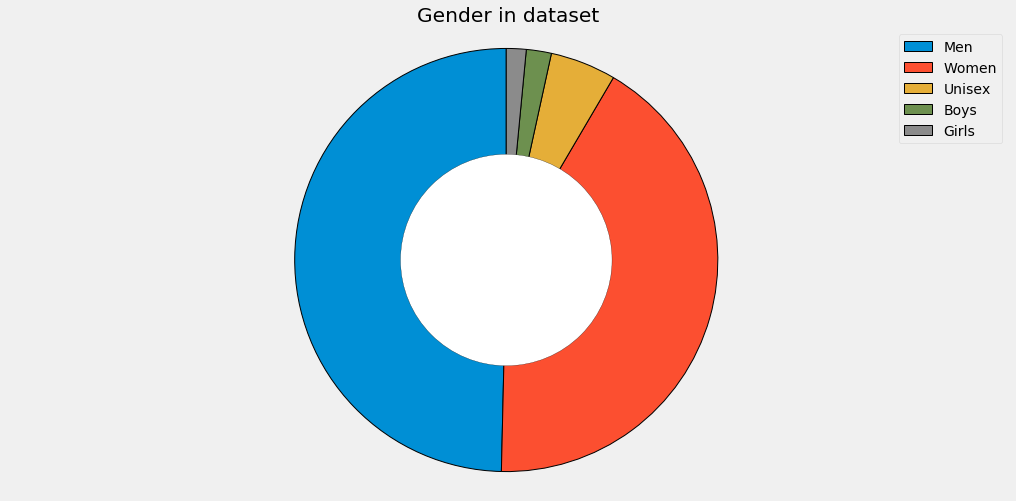

In [6]:
gender_count = style_df['gender'].value_counts()

fig, ax = plt.subplots()

ax.pie(gender_count.values,
        labels=gender_count.index,
#         autopct='%1.1f%%',
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        rotatelabels=True,
        labeldistance=None, # remove the wedge labels
#         shadow=True,
        startangle=90)

centre_circle = plt.Circle((0,0), 0.5, edgecolor='black', 
facecolor='white',fill=True,linewidth=0.25)

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.legend()
plt.axis('equal')
plt.title('Gender in dataset')
plt.show()

### Season

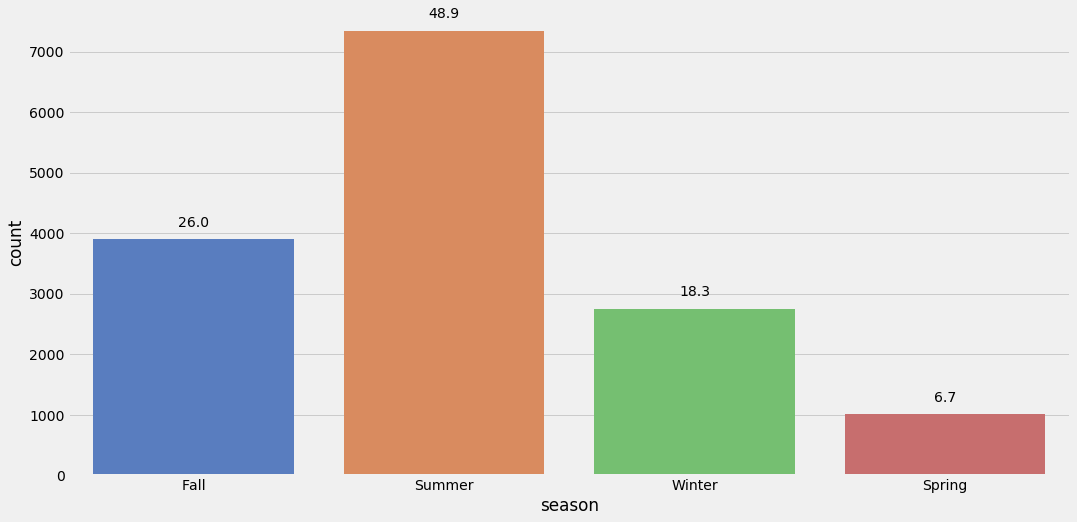

In [7]:
splot1 = sns.countplot(style_df['season'], palette='muted')

for p in splot1.patches:
    splot1.annotate(format(p.get_height() / style_df.shape[0] * 100, '.1f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    rotation=0, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

plt.show()

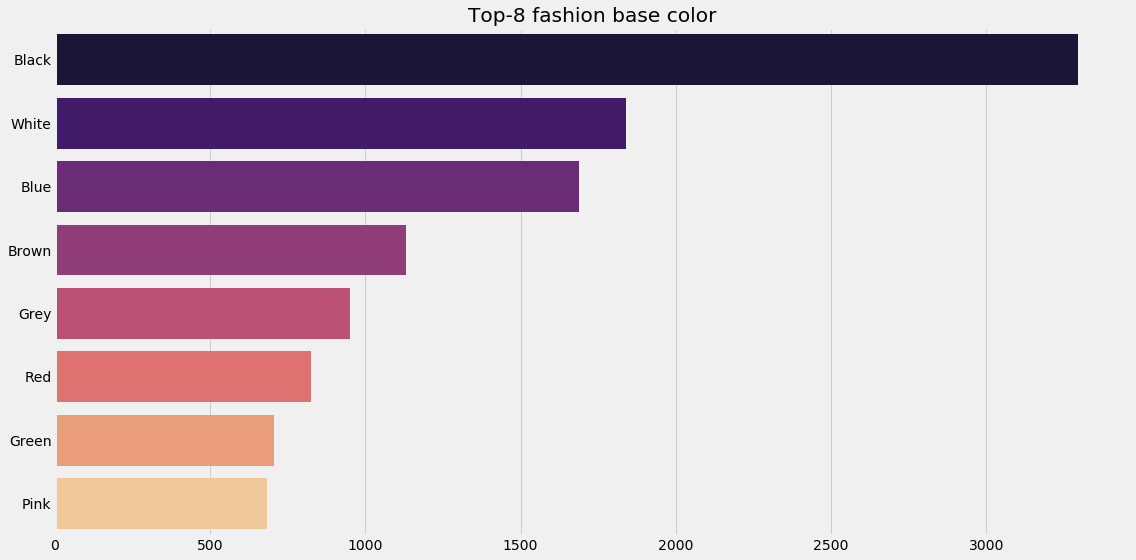

In [8]:
color_count = style_df['baseColour'].value_counts()[:8]

sns.barplot(x=color_count.values,
            y=color_count.index,
            palette='magma')

plt.title('Top-8 fashion base color')
plt.tight_layout()
plt.show()

# Convolutional Neural Network (CNN) — Deep Learning

![cnn](https://miro.medium.com/max/1280/1*uQEWL_vd0Vfp5OwhywiveA.gif)
source: [medium](https://medium.com/nybles/a-brief-guide-to-convolutional-neural-network-cnn-642f47e88ed4)

CNN is a class of deep neural networks which is mostly used to do image recognition / classification, object detection, style transfer etc. In CNN, we take an image as an input, assign importance (learnable weights and biases) to its various aspects/objects in the image and be able to differentiate one from another.

Computers see images differently than humans. they see images as pixels / matrix.

![computer-see-image](https://miro.medium.com/max/1272/0*bUvnIM6LTtdn_S3W.png)

-----------------------------------------------

### CNN performs a dot product between two matrices: each value in each pixel of input image with filter.

![convolution](https://miro.medium.com/max/1000/1*GcI7G-JLAQiEoCON7xFbhg.gif)

The main objective of convolution is to extract features such as edges, colours, corners from the input. As we go deeper inside the network (with max pooling), the network starts identifying more complex features such as shapes,digits, face parts as well. Last, CNN do the classification process using Fully-Connected Layer.

![architecture](https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

# My Experiment
    
* In his [original notebook](https://www.kaggle.com/marlesson/building-a-recommendation-system-using-cnn-v2), Marlesson used ResNet50 for extract 5000 images
* In this notebook i used EfficientNet B3 for extract 15000 images
*  Actually i already tried ResNet50, Xception too, in my opinion, the result is the same, but i recommend you to try by yourself if you're interested :)

## Model 1 - Resnet50

In [9]:
# from tensorflow.keras.applications.resnet50 import ResNet50

# resnet50_model = ResNet50(weights='imagenet',
#                  include_top=False,
#                  input_shape=(224, 224, 3),
#                  pooling='max')

# resnet50_model.trainable = False

# resnet50_model.summary()

## Model 2 - Xception

In [10]:
# from tensorflow.keras.applications.xception import Xception

# xception_model = Xception(weights='imagenet',
#                           include_top=False,
#                           pooling='max')

# xception_model.trainable = False

# xception_model.summary()

## Model 3 - Efficient-Net

In May 2019, Google published both a very exciting paper and source code for a newly designed CNN called EfficientNet, that set new records for both accuracy and computational efficiency. Here’s the results of EfficientNet, scaled to different block layers (B1, B2, etc) vs. most other popular CNN’s.

![Architecture](https://miro.medium.com/max/985/1*nQ5HYZ1xiIGn092Y5H5SIQ.jpeg)

As the image shows, EfficientNet tops the current state of the art both in accuracy and in computational efficiency. How did they do this?

### Model scaling

They learned that CNN’s must be scaled up in **depth, width, and input image resolution together** to improve the performance of the model. The scaling method is named **compound scaling** and suggests that instead of scaling only one model attribute out of depth, width, and resolution; strategically scaling all three of them together delivers better results.

There is a synergy in scaling depth, width and image-resolution together, and after an extensive grid search derived the theoretically optimal formula of “compound scaling” using the following co-efficients:

* Depth = 1.20
* Width = 1.10
* Resolution = 1.15

Depth simply means how deep the networks is which is equivalent to the number of layers in it. Width simply means how wide the network is. One measure of width, for example, is the number of channels in a Conv layer whereas Resolution is simply the image resolution that is being passed to a CNN.

In other words, to scale up the CNN, the depth of layers should increase 20%, the width 10% and the image resolution 15% to keep things as efficient as possible while expanding the implementation and improving the CNN accuracy. This compound scaling formula is used to scale up the EfficientNet from B0-B7

### Swish Activation

![swish-activation](https://miro.medium.com/max/1400/0*EhAHcCmGOzQUgQ0k)

ReLu works pretty well but it got a problem, it nullifies negative values and thus derivatives are zero for all negative values. There are many known alternatives to tackle this problem like leaky ReLu, Elu, Selu etc., but none of them has proven consistent.

Google Brain team suggested a newer activation that tends to work better for deeper networks than ReLU which is a Swish activation. They proved that if we replace Swish with ReLu on InceptionResNetV2, we can achieve 0.6% more accuracy on ImageNet dataset.

> Swish(x) = x * sigmoid(x)

There are other things like MBConv Block etc. If you want to know more details, you can read the articles in reference below

In [11]:
!pip install -q efficientnet

### In efficientNet, depth, width, and input image resolution must scaled up together

We cannot randomly adjust the resolution. I read in an article, every efficientnet model has a different image resolution input size.

* efficientnet-b0-224
* efficientnet-b1-240
* efficientnet-b2-260
* efficientnet-b3-300
* efficientnet-b4-380
* efficientnet-b5-456
* efficientnet-b6-528
* efficientnet-b7-600

In [12]:
from efficientnet.tfkeras import EfficientNetB3

efficientnet_model = EfficientNetB3(weights='imagenet',
                                        include_top=False,
                                        pooling='max')

efficientnet_model.trainable = False

efficientnet_model.summary()

44113920/44107200 [==============================] - 2s 0us/step
Model: "efficientnet-b3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
___________________

### pooling: Optional pooling mode for feature extraction when include_top is False.

![max_pooling](https://miro.medium.com/max/2344/1*ReZNSf_Yr7Q1nqegGirsMQ@2x.png)

* None means that the output of the model will be the 4D tensor output of the last convolutional block.
* 'max' means that global max pooling will be applied.
* 'avg' means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.

In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# from tensorflow.keras.applications.xception import preprocess_input

# ResNet use (224, 224)
# Xception use (299, 299)
# EfficientNet i tried (300, 300)

def get_embedding(model, img_path):
    
    img = load_img(img_path, target_size=(300, 300))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    return model.predict(img).reshape(-1)

In [14]:
def show_image(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

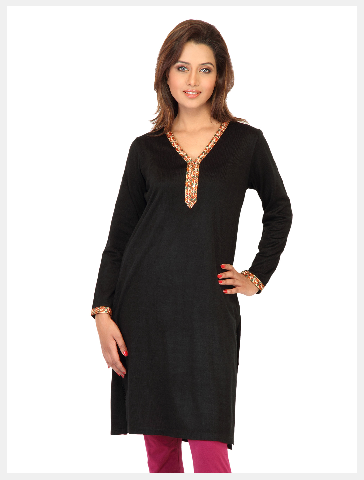

In [15]:
show_image(style_df.iloc[4548].image_path)

In [16]:
img_embed = get_embedding(efficientnet_model, style_df.iloc[4548].image_path)

print('Image shape after embedding:', img_embed.shape)
print(img_embed)

Image shape after embedding: (1536,)
[1.3892496 6.9255714 5.444406  ... 1.1163081 8.355721  0.7111667]


Output shape comparison:

* Resnet50: 2048
* Xception: 2048
* EfficientNet B3: 1536

> ## There is one image that error when opened, since it will making training crash, we should drop this

In [17]:
style_df.drop([6695], inplace=True)

## Options before you train the model:

* This will take approximately 45 minutes to train using GPU
* I already trained & saved this model to csv format, so we can load and using it without training (similar to transfer learning)
* You can [download the csv file here](https://www.kaggle.com/indralin/fashion-embedding-weights-in-csv)

But if you're curious, you can train the model with different model, just uncomment codes below..

In [18]:
# %%time

# map_embeddings = style_df['image_path'].apply(lambda img_path: get_embedding(efficientnet_model, img_path))
# df_embs = map_embeddings.apply(pd.Series)

In [19]:
# load the model
df_embs = pd.read_csv('/kaggle/input/fashion-embedding-weights-in-csv/fashion_embedding.csv')
df_embs.drop(['Unnamed: 0'], axis=1, inplace=True)

print('df_embs shape:', df_embs.shape)

df_embs shape: (14999, 1536)


In [20]:
df_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,-0.003615,1.546540,1.273071,3.257491,2.353817,0.458900,2.041577,7.754831,5.230895,0.619670,...,4.405729,0.028123,1.527538,0.838933,4.922432,1.922090,0.256389,5.777333,4.323022,0.858838
1,-0.023795,4.420555,1.503665,4.546736,2.421621,0.958892,0.970872,6.945242,5.857317,-0.000367,...,4.401929,0.675276,1.367281,2.197742,9.290089,0.974344,0.640318,5.702991,2.880010,0.637729
2,8.502352,2.418041,8.016090,10.175487,2.455585,0.453091,1.016536,2.427743,0.485105,7.991472,...,3.834892,0.869452,4.614962,6.392833,1.353293,0.610157,2.400109,3.286546,0.765979,2.666506
3,0.817173,4.442902,3.355861,5.303558,2.807511,0.779979,3.216202,13.057469,6.291018,0.086129,...,3.735286,1.239339,3.912739,3.015040,6.522589,0.125734,3.708895,3.655752,2.502867,0.786082
4,2.798334,4.240894,1.290832,7.001908,1.580255,3.480205,1.178784,10.013133,6.744488,-0.008754,...,7.796361,1.918521,1.345106,0.734219,5.863018,0.819060,2.357108,7.226751,1.408554,1.495523


In [21]:
from sklearn.metrics.pairwise import pairwise_distances

# Calculate Distance Matrix
cosine_sim = 1 - pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.87515851, 0.56525799, 0.84217019],
       [0.87515851, 1.        , 0.55073537, 0.83637166],
       [0.56525799, 0.55073537, 1.        , 0.58631807],
       [0.84217019, 0.83637166, 0.58631807, 1.        ]])

## Make a function

In [22]:
indices = pd.Series(range(len(style_df)), index=style_df.index)

# Function to get recommendations based on the cosine similarity score
def get_recommender1(idx, top_n = 6):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1: top_n+1]
    
    idx_rec    = [i[0] for i in sim_scores] # index
    idx_sim    = [i[1] for i in sim_scores] # similarity
    
    return indices.iloc[idx_rec].index, idx_sim

def get_recommender2(idx, top_n = 6):
    sim_idx    = indices[idx+1]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1: top_n+1]
    
    idx_rec    = [i[0] for i in sim_scores] # index
    idx_sim    = [i[1] for i in sim_scores] # similarity
    
    return indices.iloc[idx_rec].index, idx_sim

def load_image(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plot_figures(figures, nrows = 2, ncols=3, figsize=(8, 8)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for ind, title in enumerate(figures):
        # walaupun 2x3 tetap bisa di-loop klo di-ravel
        axes.ravel()[ind].imshow(figures[title])
        axes.ravel()[ind].set_title(title)
        axes.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def show_recommender(idx):
    '''
    Function: Give a recommendation based on similarity between product image
    Input: image index (number between 0 - 14998)
    '''
    try:
        if idx < 6695:
    
            # Recommendations
            idx_rec, idx_sim = get_recommender1(idx)
    
            # Plot
            plt.imshow(load_image(style_df.iloc[idx].image_path))
            plt.title(style_df.iloc[idx].productDisplayName)
            plt.axis('off')
    
            # generation of a dictionary of (title, images)
            figures = {'im ' + str(i): load_image(row.image_path) for i, row in style_df.loc[idx_rec].iterrows()}
    
            # plot of the images in a figure, with 2 rows and 3 columns
            plot_figures(figures)
        
        elif idx > 6695:
        
            # Recommendations
            idx_rec, idx_sim = get_recommender2(idx)
    
            # Plot
            plt.imshow(load_image(style_df.iloc[idx].image_path))
            plt.title(style_df.iloc[idx].productDisplayName)
            plt.axis('off')
    
            # generation of a dictionary of (title, images)
            figures = {'im ' + str(i-1): load_image(row.image_path) for i, row in style_df.loc[idx_rec].iterrows()}
    
            # plot of the images in a figure, with 2 rows and 3 columns
            plot_figures(figures)
        
    except:
        print('Please insert a number between 0 - 14998\nPlease notice: insert number 6695 will throw an error')

### Notes

* We dropped one row in dataset, this make some of index in recommendation to be inappropriate
* Sometimes the recommendation index must be reduced by 1 or add by 1

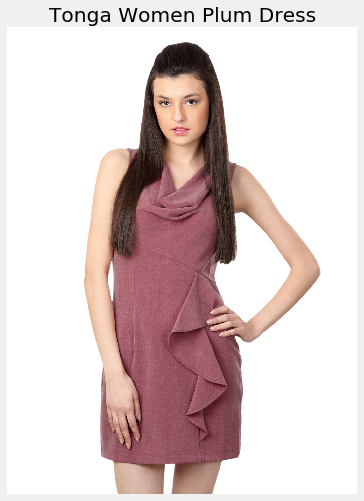

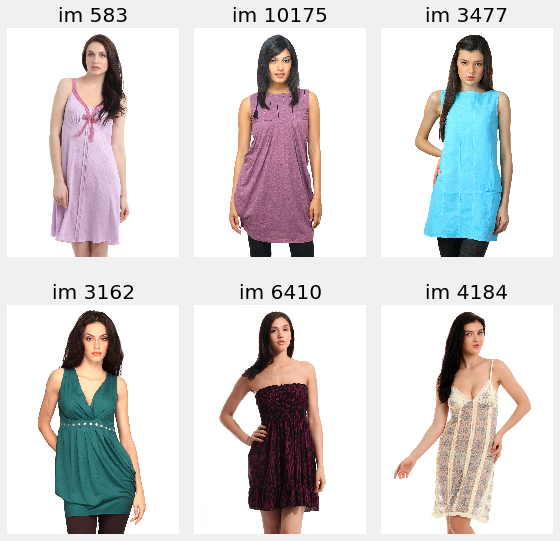

In [23]:
show_recommender(12823)

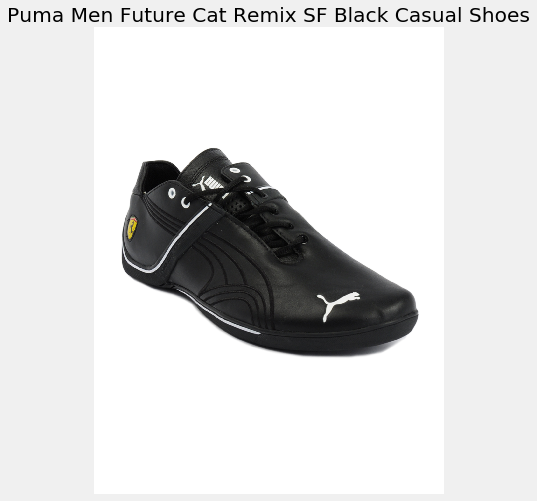

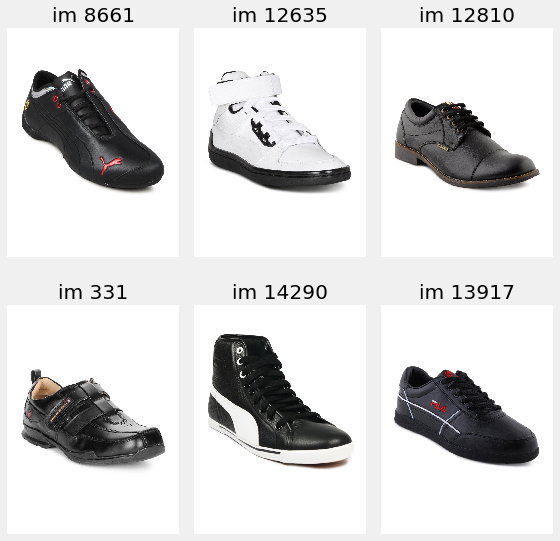

In [24]:
show_recommender(10)

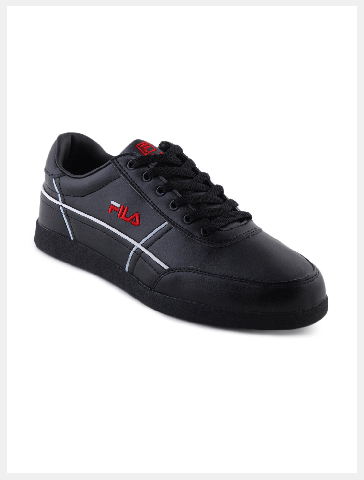

In [25]:
# checking example, the index must be add by 1
# If you're interesed, you can try to fix the algorithm
show_image(style_df.iloc[13916].image_path)

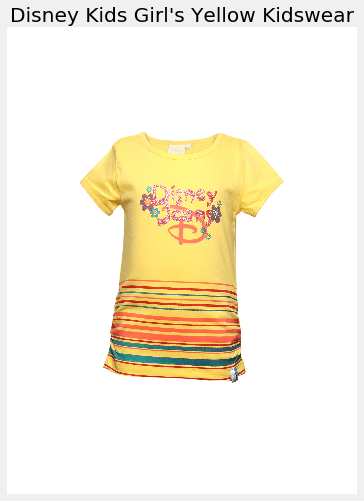

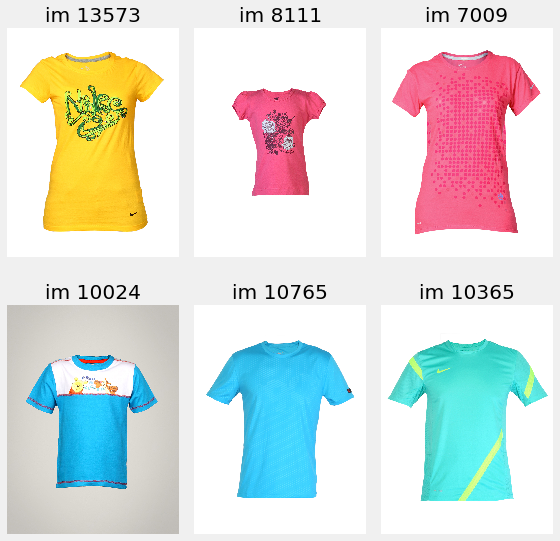

In [26]:
show_recommender(14500)

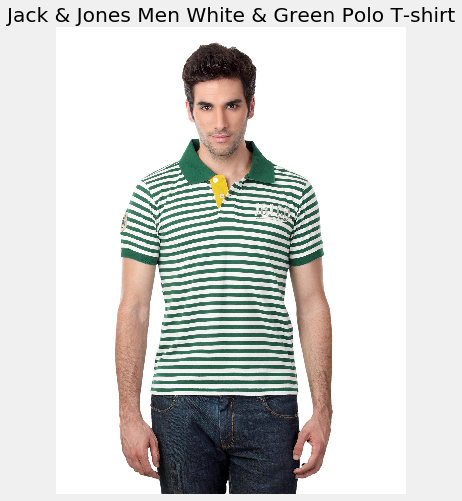

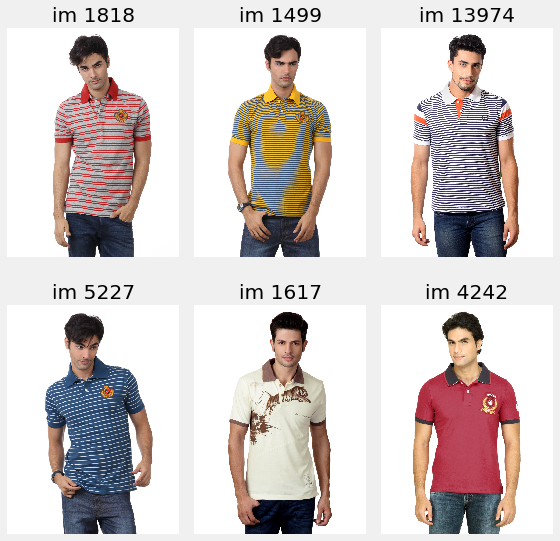

In [27]:
show_recommender(13321)

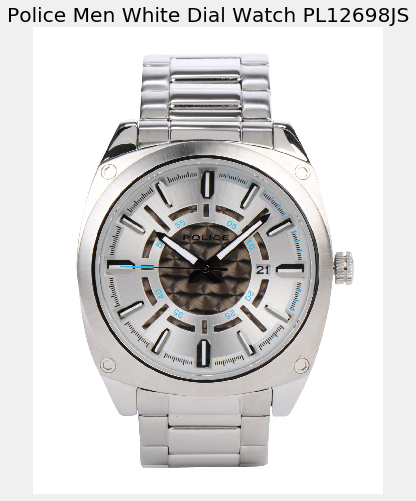

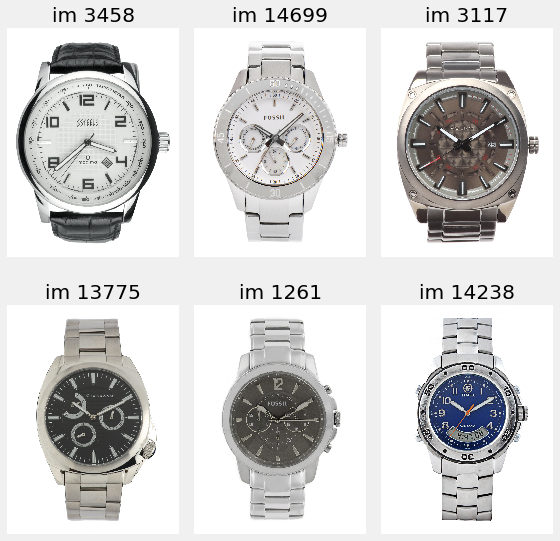

In [28]:
show_recommender(223)

In [29]:
show_recommender(20000)

Please insert a number between 0 - 14998
Please notice: insert number 6695 will throw an error


# reference:

[Original Notebook](https://www.kaggle.com/marlesson/building-a-recommendation-system-using-cnn-v2)

[EfficientNet from Google — Optimally Scaling CNN model architectures with “compound scaling”](https://medium.com/@lessw/efficientnet-from-google-optimally-scaling-cnn-model-architectures-with-compound-scaling-e094d84d19d4)

[Image Classification with EfficientNet: Better performance with computational efficiency](https://medium.com/analytics-vidhya/image-classification-with-efficientnet-better-performance-with-computational-efficiency-f480fdb00ac6)

[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://medium.com/@nainaakash012/efficientnet-rethinking-model-scaling-for-convolutional-neural-networks-92941c5bfb95)